# In this tutorial we will show the typical workflow for the construcion of the Reduced Order Model.

In this tutorial we will consider the following example: (TODO: Problem description here)

<img src="pictures/tut1_sketch.png" alt="Drawing" style="width: 300px;"/>
The exaple and the picture are from the book  Certified reduced basis methods for parametrized partial differential equations, JS Hesthaven, G Rozza, B Stamm, 2016, Springer.

First of all import the required packages.

In [1]:
import numpy as np
from ezyrb import POD, RBF, Database, Scale
from ezyrb import ReducedOrderModel as ROM

import matplotlib.tri as mtri
import matplotlib.pyplot as plt

## Ofline phase

Import the high-fidelity solutions (*snapshots*) and the related parameters.

In [2]:
snapshots = np.load('data/tut1_snapshots.npy')
param = np.load('data/tut1_mu.npy')

Import the mesh information and create a triangulation(only for plots in this example)

In [3]:
tri = np.load('data/tut1_triangles.npy')
coord = np.load('data/tut1_coord.npy')
triang = mtri.Triangulation(coord[0],coord[1],tri)

For the sake of clarity the snapshots are plotted.

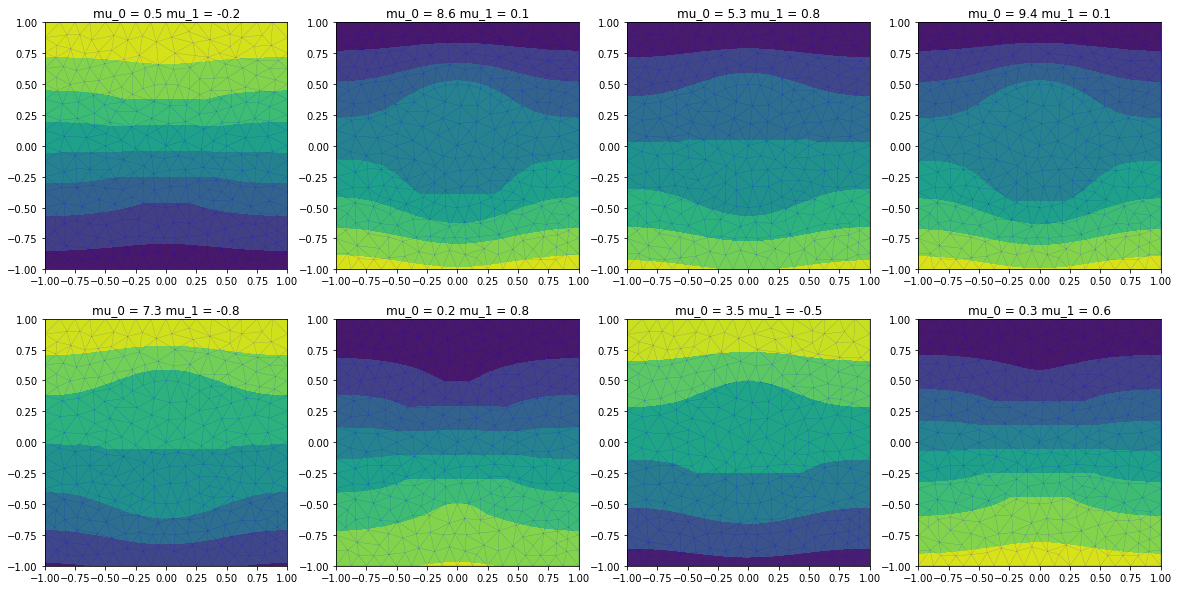

In [4]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(nrows=2, ncols=4)
ax = ax.flatten()
for i in range(8):
   ax[i].triplot(triang, 'b-', lw=0.1)
   ax[i].tricontourf(triang, snapshots[i])
   ax[i].set_title('mu_0 = ' + str(param[i][0].round(2)) + ' mu_1 = ' + str(param[i][1].round(2)))

Create a database object from the paramerts and the snapshots.

In [5]:
db = Database(param, snapshots, scaler_snapshots=Scale('minmax'))

Then create a reduction object. In this case a POD object.
To compute the reduces space one of these methods can be choosen
- *svd*
- *srandomized_svd*
- *correlation_matrix*

In [6]:
pod = POD('svd')

Create Approximation object. In this case Radial Basis Function Interpolation

In [7]:
rbf = RBF()

Create Reduced Order Model object with the previously created objects.
The fit() function computes the reduced space.

In [8]:
rom = ROM(db, pod, rbf)
rom.fit()

## Online phase
Predict solution for a new parameter mu that is not in the training set.

In [9]:
mu = [8,   1]
pred_sol = rom.predict(mu)

Plot the prdictet solution

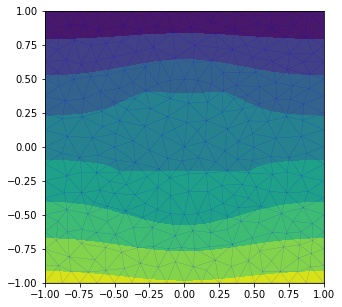

In [10]:
plt.rcParams["figure.figsize"] = (5,5)
plt.triplot(triang, 'b-', lw=0.1)
plt.tricontourf(triang, pred_sol)

## Error Approximation & Improvement

At the moment, the database is composed by 4 files. Before proceding with the reduced basis space generation, we would have an idea of the approximation accuracy we are able to reach with these high-fidelity solutions. The library provides an efficient *a priori* error estimator.

In [11]:
rom.loo_error()

array([0.63452816, 0.8784491 , 2.78634492, 1.2468169 , 3.07896457,
       0.42578798, 0.48141642, 0.25291043])

Using the *leave-one-out* strategy, an error is computed for each parametric point in our database and these values are returned as array. Moreover, we can use the information about the errors to locate the parametric points where we have to compute the new high-fidelity solutions and add these to the database in order to optimally improve the accuracy.

In [12]:
rom.optimal_mu()

[array([ 6.13371799, -0.07481085])]

These function can be used to achieve the wanted (estimated) accuracy. An iterative example is:

In [13]:
error = rom.loo_error()
eps = 0.07
while max(error) > eps:
    
    new_points = rom.optimal_mu(error)
    print('Current estimated error: {}'.format(max(error)))
    print('Optimal parametric points:')
    
    for point in new_points:
        print('\t{}'.format(point))
    break   
    for point in new_points:
        # Compute the high-fidelity solution now...
        filename = input('Solution file for point {}: ')
        rom.add_snapshot(point, filename)
    
    error = rom.loo_error()

Current estimated error: 3.0789645690357155
Optimal parametric points:
	[ 6.13371799 -0.07481085]
